CSML1010 Group3 Course_Project - Feature Engineering

#### Import Libraries

In [86]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [87]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

#### Load Data

In [88]:
import sqlite3

sql = """
SELECT p.*
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df = pd.read_sql_query(sql, con)

#### Get relevant columns

In [89]:
sql = """
SELECT p.selfdialog_clean, p.instruction_id
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    corpus_df = pd.read_sql_query(sql, con)

corpus_df.head(5)

,selfdialog_clean,Instruction_id
0,"Hi, I'm looking to book a table for Korean fod. Ok, what area are you thinking about? Somewhere in Southern NYC, maybe the East Village? Ok, great. There's Thursday Kitchen, it has great reviews. That's great. So I need a table for tonight at 7 pm for 8 people. We don't want to sit at the bar, but anywhere else is fine. They don't have any availability for 7 pm. What times are available? 5 or 8. Yikes, we can't do those times. Ok, do you have a second choice? Let me check. Ok. Lets try Boka, are they free for 8 people at 7? Yes. Great, let's book that. Ok great, are there any other requests? No, that's it, just book. Great, should I use your account you have open with them? Yes please. Great. You will get a confirmation to your phone soon.",restaurant-table-2
1,"Hi I would like to see if the Movie What Men Want is playing here. Yes it's showing here would you like to purchase a ticket? Yes, for me and a friend so two tickets please Okay. What time is that moving playing today? That movie is showing at 4, 5, and 8pm. Okay. Is there anymore movies showing around 8pm Yes , showing at 8pm is Green Book. What is that about? It's about two men dealing with racisim. Oh, no can you recommend anything else? What do you like? Well I like movies that are funny. Like comedies? Well no I like action as well. Okay. How to train your dragon is playing at 8pm. Okay can i get two tickets for that ? So you want me to cancel the tickets for What men want ? Yes please. Okay, no problem. How much will this cost. You said two adult tickets? Yes. Okay, that will be $20.80 Okay. Anything else I can help you with ? Yes can i bring my own food to theater. No, sorry you have to purchase food in the lobby. Okay that is fine. Thank you enjoy your movie",movie-tickets-1
2,"I want to watch avengers endgame where do you want to watch it at? at bangkok close the hotel I a currently staying sounds good, what time do you want to watch the movie? 8 o'clock how many tickets? two and should we use the account we already have with the movie theater? yes It seems they do not have any movie at that time let's watch another movie then what other movie do you want to watch let's watch how to train your dragon the newest one yes, that one I don't think that movie is playing at that time either so neither choices are playing at the time I want to watch I am afraid so I am no longer interested in watching the movie very well, have a great day sir thank you you are welcome",movie-tickets-3
3,"I want to order a pizza from Bertuccis in Chelmsford, MA what type of pizza would you like? a silano what size a large please understood. will do thanks unfortunately bertuccis has run out of broccoli and so are not offering the silano style pizza today I see would you like a different type of pizza? yes. i would like a sporkie pizza what size would you like? large ok. I have confirmed your order for a large sporkie pizza at the bertuccis in chelmsford, ma very good would you like anything else? no thank you you will be receiving a text message on your phone confirming the details of your order including the receipt and will be ready for pick up in 25 minutes great. thank you so much you're welcome. glad i could be of assistance",pizza-ordering-2
4,"Hi I'd like to order two large pizzas. Sure, what kind of pizzas to you have in mind? I'll have a Hawaiian please. sure, is there anything else I can get for you? Yes, I'd like a large meat lover pizza please. I am sorry, we're currently out of the meat lover pizza. Is there anything else you'd like instead? Sure. I'd like a buffalo chicken pizza please. Sure thing. What size do you want your buffalo chicken pizza? Large please. What kind of crust do you want for your Hawaiian pizza? Hand tossed please. What kind of crust do you want for you buffalo chicken pizza? Also hand tossed please. thank you very much. Is there anything else I can get for you? No, that's it for today. Thank you My pleasure. So we 

In [90]:
corpus_df['category'] = corpus_df['Instruction_id'].factorize()[0]
corpus_df.head(5)

,selfdialog_clean,Instruction_id,category
0,"Hi, I'm looking to book a table for Korean fod. Ok, what area are you thinking about? Somewhere in Southern NYC, maybe the East Village? Ok, great. There's Thursday Kitchen, it has great reviews. That's great. So I need a table for tonight at 7 pm for 8 people. We don't want to sit at the bar, but anywhere else is fine. They don't have any availability for 7 pm. What times are available? 5 or 8. Yikes, we can't do those times. Ok, do you have a second choice? Let me check. Ok. Lets try Boka, are they free for 8 people at 7? Yes. Great, let's book that. Ok great, are there any other requests? No, that's it, just book. Great, should I use your account you have open with them? Yes please. Great. You will get a confirmation to your phone soon.",restaurant-table-2,0
1,"Hi I would like to see if the Movie What Men Want is playing here. Yes it's showing here would you like to purchase a ticket? Yes, for me and a friend so two tickets please Okay. What time is that moving playing today? That movie is showing at 4, 5, and 8pm. Okay. Is there anymore movies showing around 8pm Yes , showing at 8pm is Green Book. What is that about? It's about two men dealing with racisim. Oh, no can you recommend anything else? What do you like? Well I like movies that are funny. Like comedies? Well no I like action as well. Okay. How to train your dragon is playing at 8pm. Okay can i get two tickets for that ? So you want me to cancel the tickets for What men want ? Yes please. Okay, no problem. How much will this cost. You said two adult tickets? Yes. Okay, that will be $20.80 Okay. Anything else I can help you with ? Yes can i bring my own food to theater. No, sorry you have to purchase food in the lobby. Okay that is fine. Thank you enjoy your movie",movie-tickets-1,1
2,"I want to watch avengers endgame where do you want to watch it at? at bangkok close the hotel I a currently staying sounds good, what time do you want to watch the movie? 8 o'clock how many tickets? two and should we use the account we already have with the movie theater? yes It seems they do not have any movie at that time let's watch another movie then what other movie do you want to watch let's watch how to train your dragon the newest one yes, that one I don't think that movie is playing at that time either so neither choices are playing at the time I want to watch I am afraid so I am no longer interested in watching the movie very well, have a great day sir thank you you are welcome",movie-tickets-3,2
3,"I want to order a pizza from Bertuccis in Chelmsford, MA what type of pizza would you like? a silano what size a large please understood. will do thanks unfortunately bertuccis has run out of broccoli and so are not offering the silano style pizza today I see would you like a different type of pizza? yes. i would like a sporkie pizza what size would you like? large ok. I have confirmed your order for a large sporkie pizza at the bertuccis in chelmsford, ma very good would you like anything else? no thank you you will be receiving a text message on your phone confirming the details of your order including the receipt and will be ready for pick up in 25 minutes great. thank you so much you're welcome. glad i could be of assistance",pizza-ordering-2,3
4,"Hi I'd like to order two large pizzas. Sure, what kind of pizzas to you have in mind? I'll have a Hawaiian please. sure, is there anything else I can get for you? Yes, I'd like a large meat lover pizza please. I am sorry, we're currently out of the meat lover pizza. Is there anything else you'd like instead? Sure. I'd like a buffalo chicken pizza please. Sure thing. What size do you want your buffalo chicken pizza? Large please. What kind of crust do you want for your Hawaiian pizza? Hand tossed please. What kind of crust do you want for you buffalo chicken pizza? Also hand tossed please. thank you very much. Is there anything else I can get for you? No, that's it for today. Thank you My

#### Word Embeddings

In [91]:
df.columns

Index(['index', 'id', 'Conversation', 'Instruction_id', 'service_type',
       'selfdialog_clean', 'selfdialog_lemma', 'selfdialog_nouns',
       'selfdialog_adjectives', 'selfdialog_verbs', 'selfdialog_nav',
       'no_tokens'],
      dtype='object')

In [102]:
corpus_df.columns

Index(['selfdialog_clean', 'Instruction_id', 'category', 'selfdialog_norm'], dtype='object')

#### Do Some Additional CLeaning

In [124]:
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    #doc = "'" + doc + "'"
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    #doc = [[word.lower() for word in sent if word not in remove_terms] for sent in doc]
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [153]:
for i, row in corpus_df.iterrows():
    corpus_df.at[i, "selfdialog_norm"] = normalize_corpus(row.selfdialog_clean) 

corpus_df.head(3)

,selfdialog_clean,Instruction_id,category,selfdialog_norm
0,"Hi, I'm looking to book a table for Korean fod. Ok, what area are you thinking about? Somewhere in Southern NYC, maybe the East Village? Ok, great. There's Thursday Kitchen, it has great reviews. That's great. So I need a table for tonight at 7 pm for 8 people. We don't want to sit at the bar, but anywhere else is fine. They don't have any availability for 7 pm. What times are available? 5 or 8. Yikes, we can't do those times. Ok, do you have a second choice? Let me check. Ok. Lets try Boka, are they free for 8 people at 7? Yes. Great, let's book that. Ok great, are there any other requests? No, that's it, just book. Great, should I use your account you have open with them? Yes please. Great. You will get a confirmation to your phone soon.",restaurant-table-2,0,hi im looking book table korean fod ok area thinking somewhere southern nyc maybe east village ok great theres thursday kitchen great reviews thats great need table tonight pm people dont want sit bar anywhere else fine dont availability pm times available yikes cant times ok second choice let check ok lets try boka free people yes great lets book ok great requests thats book great use account open yes please great get confirmation phone soon
1,"Hi I would like to see if the Movie What Men Want is playing here. Yes it's showing here would you like to purchase a ticket? Yes, for me and a friend so two tickets please Okay. What time is that moving playing today? That movie is showing at 4, 5, and 8pm. Okay. Is there anymore movies showing around 8pm Yes , showing at 8pm is Green Book. What is that about? It's about two men dealing with racisim. Oh, no can you recommend anything else? What do you like? Well I like movies that are funny. Like comedies? Well no I like action as well. Okay. How to train your dragon is playing at 8pm. Okay can i get two tickets for that ? So you want me to cancel the tickets for What men want ? Yes please. Okay, no problem. How much will this cost. You said two adult tickets? Yes. Okay, that will be $20.80 Okay. Anything else I can help you with ? Yes can i bring my own food to theater. No, sorry you have to purchase food in the lobby. Okay that is fine. Thank you enjoy your movie",movie-tickets-1,1,hi would like see movie men want playing yes showing would like purchase ticket yes friend two tickets please okay time moving playing today movie showing pm okay anymore movies showing around pm yes showing pm green book two men dealing racisim oh recommend anything else like well like movies funny like comedies well like action well okay train dragon playing pm okay get two tickets want cancel tickets men want yes please okay problem much cost said two adult tickets yes okay okay anything else help yes bring food theater sorry purchase food lobby okay fine thank enjoy movie
2,"I want to watch avengers endgame where do you want to watch it at? at bangkok close the hotel I a currently staying sounds good, what time do you want to watch the movie? 8 o'clock how many tickets? two and should we use the account we already have with the movie theater? yes It seems they do not have any movie at that time let's watch another movie then what other movie do you want to watch let's watch how to train your dragon the newest one yes, that one I don't think that movie is playing at that time either so neither choices are playing at the time I want to watch I am afraid so I am no longer interested in watching the movie very well, have a great day sir thank you you are welcome",movie-tickets-3,2,want watch avengers endgame want watch bangkok close hotel currently staying sounds good time want watch movie oclock many tickets two use account already movie theater yes seems movie time lets watch another movie movie want watch lets watch train dragon newest one yes one dont think movie playing time either neither choices playing time want watch afraid longer interested watching movie well great day sir than

In [155]:
doc_series = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm.tolist())

print(len(doc_lst))
doc_lst[1:7]

30832


['hi would like see movie men want playing yes showing would like purchase ticket yes friend two tickets please okay time moving playing today movie showing pm okay anymore movies showing around pm yes showing pm green book two men dealing racisim oh recommend anything else like well like movies funny like comedies well like action well okay train dragon playing pm okay get two tickets want cancel tickets men want yes please okay problem much cost said two adult tickets yes okay okay anything else help yes bring food theater sorry purchase food lobby okay fine thank enjoy movie',
 'want watch avengers endgame want watch bangkok close hotel currently staying sounds good time want watch movie oclock many tickets two use account already movie theater yes seems movie time lets watch another movie movie want watch lets watch train dragon newest one yes one dont think movie playing time either neither choices playing time want watch afraid longer interested watching movie well great day sir 

#### Build Vocabulary

In [156]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(doc_lst)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in doc_lst]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 17504
Vocabulary Sample: [('like', 1), ('would', 2), ('ok', 3), ('okay', 4), ('yes', 5), ('want', 6), ('order', 7), ('pm', 8), ('pizza', 9), ('thank', 10)]


#### Build (context_words, target_word) pair generator

In [157]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [158]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['hi', 'im', 'book', 'table'] -> Target (Y): looking
Context (X): ['im', 'looking', 'table', 'korean'] -> Target (Y): book
Context (X): ['looking', 'book', 'korean', 'fod'] -> Target (Y): table
Context (X): ['book', 'table', 'fod', 'ok'] -> Target (Y): korean
Context (X): ['table', 'korean', 'ok', 'area'] -> Target (Y): fod
Context (X): ['korean', 'fod', 'area', 'thinking'] -> Target (Y): ok
Context (X): ['fod', 'ok', 'thinking', 'somewhere'] -> Target (Y): area
Context (X): ['ok', 'area', 'somewhere', 'southern'] -> Target (Y): thinking
Context (X): ['area', 'thinking', 'southern', 'nyc'] -> Target (Y): somewhere
Context (X): ['thinking', 'somewhere', 'nyc', 'maybe'] -> Target (Y): southern
Context (X): ['somewhere', 'southern', 'maybe', 'east'] -> Target (Y): nyc


#### Build CBOW Deep Network Model

In [159]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))

cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print(cbow.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 4, 100)            1750400   
_________________________________________________________________
lambda_2 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 17504)             1767904   
Total params: 3,518,304
Trainable params: 3,518,304
Non-trainable params: 0
_________________________________________________________________
None


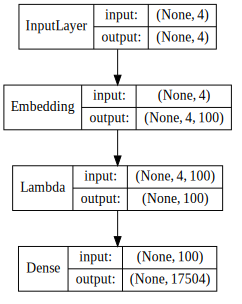

In [160]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi=70).create(prog='dot', format='svg'))

#### Train model for 5 epochs

In [147]:
for epoch in range(1, 6):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Processed 400000 (context, word) pairs
Processed 500000 (context, word) pairs
Processed 600000 (context, word) pairs
Processed 700000 (context, word) pairs
Processed 800000 (context, word) pairs
Processed 900000 (context, word) pairs
Processed 1000000 (context, word) pairs


KeyboardInterrupt: 

### Get word embeddings

In [161]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

(17503, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
would,0.03,-0.02,-0.05,0.00,-0.05,0.02,0.05,0.02,-0.02,-0.03,0.01,-0.02,-0.03,-0.01,0.04,...,-0.01,0.01,-0.03,0.02,-0.01,-0.02,0.01,-0.05,-0.03,-0.02,0.00,0.02,0.01,-0.00,0.03
ok,0.01,-0.03,0.03,-0.03,0.02,0.01,0.04,-0.04,-0.03,0.02,0.02,0.01,0.02,0.04,0.03,...,0.03,-0.00,0.05,-0.01,0.03,0.02,0.01,-0.03,0.02,-0.00,-0.04,-0.04,-0.03,-0.03,-0.01
okay,-0.02,-0.04,-0.02,0.04,-0.05,0.01,0.00,-0.05,0.04,-0.03,-0.01,-0.02,-0.01,-0.02,-0.00,...,-0.04,0.03,-0.00,-0.03,0.03,-0.00,0.00,0.02,-0.01,-0.03,0.02,0.03,-0.03,-0.02,0.04
yes,-0.03,0.04,-0.01,0.01,0.01,0.01,0.00,-0.04,-0.04,-0.01,0.03,-0.03,-0.00,-0.04,-0.03,...,-0.03,0.03,0.03,0.04,-0.05,-0.03,-0.03,-0.03,0.02,0.00,0.03,0.03,0.04,0.01,-0.01
want,-0.04,0.02,0.03,-0.03,-0.05,-0.04,-0.02,0.01,-0.02,-0.03,-0.03,-0.04,-0.03,0.05,0.02,...,0.02,0.05,-0.03,-0.02,0.02,-0.04,-0.02,0.01,0.02,0.03,0.01,-0.01,0.05,-0.01,0.04


#### Build a distance matrix to view the most similar words (contextually)

In [162]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}

similar_words

(17503, 17503)
